# Lending Club Loan Default Predictions 1
**Author: Thomas Loeber**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data-and-saved-models" data-toc-modified-id="Load-data-and-saved-models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data and saved models</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Random-forests" data-toc-modified-id="Random-forests-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random forests</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Ridge/Lasso-+-LogisticRegressionCV" data-toc-modified-id="Ridge/Lasso-+-LogisticRegressionCV-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Ridge/Lasso + LogisticRegressionCV</a></span></li><li><span><a href="#SGDClassifier-(elastic-net)-+-GridSearchCV" data-toc-modified-id="SGDClassifier-(elastic-net)-+-GridSearchCV-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>SGDClassifier (elastic net) + GridSearchCV</a></span></li></ul></li><li><span><a href="#Load-pickled-data" data-toc-modified-id="Load-pickled-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load pickled data</a></span></li></ul></div>

In [23]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import missingno  # for visualizing missing data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.utils import resample

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

## Load data and saved models

In [3]:
# Load original data
with open('data_processed/all_data.pickle', 'rb') as pickled_file: 
    all_data = pickle.load(pickled_file) 

In [ ]:
# Load preprocessed data and models


## Preprocessing

In [4]:
# Train-test split (for now only select 1% for training)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(all_data.drop('default', axis='columns'),
                     all_data.default,
                     test_size=0.99, random_state=1,
                     shuffle=True, stratify=all_data.default) 

In [29]:
# Create smaller test set
X_test_small, y_test_small = resample(
    X_test, y_test, replace=False, 
    n_samples= 10000, random_state=1)

In [5]:
# Imputation and standardization for numeric features
numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Imputation and one-hot encoding for categorical features
categorical_features = X_train.select_dtypes(include=[object]).columns
categorical_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())])

# Combining preprocessing for both kinds of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('', categorical_transformer, categorical_features)],
    remainder='passthrough', n_jobs=3)

# Apply preprocessing
X_train_p = preprocessor.fit_transform(X_train)

X_test_small_p = preprocessor.transform(X_test_small)

In [41]:
# Save preprocessed data
for split_data in ['X_train_p', 'X_test_small_p', 'y_train', 'y_test_small']:
    joblib.dump(split_data,
                'data_processed/{}.joblib'.format(split_data))

In [42]:
X_train_p.shape

(10233, 168)

In [65]:
# Look how imbalanced our data are
y_train.value_counts()

0    8139
1    2094
Name: default, dtype: int64

In [67]:
y_test_small.value_counts()

0    7950
1    2050
Name: default, dtype: int64

## PCA

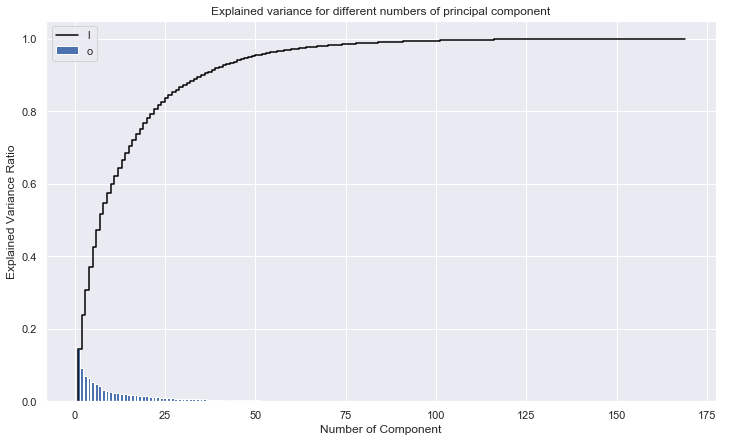

In [6]:
# Use PCA to assess whether features lie in lower-
# dimensional subspace
pca = PCA()
pca.fit(X_train_p)
explained_var = pca.explained_variance_ratio_

# Plot results
plt.figure(figsize=(12, 7))
plt.step(range(1, len(explained_var)+2),
         np.hstack([[0], np.cumsum(explained_var)]),
         color='black', label='Cumulative')
plt.bar(range(1, len(explained_var)+1),
        explained_var, 
        label='per principal component')
plt.legend('lowerright')
plt.title('Explained variance for different numbers of principal component')
plt.ylim(0,1.05)
plt.xlabel('Number of Component')
plt.ylabel('Explained Variance Ratio')
plt.show();

## Random forests

In [43]:
rf = RandomForestClassifier(n_estimators=100, 
        oob_score=True, n_jobs=3, random_state=1,
        class_weight='balanced_subsample')
rf.fit(X_train_p, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=3, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [44]:
rf.oob_score_

0.999413661682791

In [45]:
rf.score(X_test_small_p, y_test_small)

0.9998

## Logistic regression
### Ridge/Lasso + LogisticRegressionCV

In [53]:
# Ridge CV, stochastic gradient descent
lr_ridge_cv = LogisticRegressionCV(Cs = 4, solver='saga', cv=3,
    random_state=1, penalty='l2', class_weight='balanced')
lr_ridge_cv.fit(X_train_p, y_train) 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

LogisticRegressionCV(Cs=4, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
           refit=True, scoring=None, solver='saga', tol=0.0001, verbose=0)

In [54]:
# Performance during cross-validation
lr_ridge_cv.scores_

{1: array([[0.85019056, 0.99794782, 0.99736148, 0.99765465],
        [0.88155966, 1.        , 1.        , 1.        ],
        [0.87716212, 0.99970683, 0.99970683, 0.99970683]])}

In [55]:
# Performance on test set
lr_ridge_cv.score(X_test_small_p, y_test_small)

0.9991

**Try more iterations**

In [56]:
# Try more iterations (Ridge CV, stochastic gradient descent)
lr_ridge_cv = LogisticRegressionCV(Cs = 4, solver='saga', cv=3,
    random_state=1, penalty='l2', class_weight='balanced', 
    max_iter=1000)
lr_ridge_cv.fit(X_train_p, y_train) 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegressionCV(Cs=4, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
           refit=True, scoring=None, solver='saga', tol=0.0001, verbose=0)

In [57]:
# Performance during cross-validation
lr_ridge_cv.scores_

{1: array([[0.85019056, 0.99824099, 0.99882732, 0.99882732],
        [0.88155966, 1.        , 1.        , 1.        ],
        [0.87716212, 0.99970683, 1.        , 1.        ]])}

In [58]:
# Performance on test set
lr_ridge_cv.score(X_test_small_p, y_test_small)

1.0

In [68]:
# Try default solver (Ridge CV, more iterations)
lr_ridge_cv_2 = LogisticRegressionCV(Cs = 4, cv=3,
    random_state=1, penalty='l2', class_weight='balanced',
    max_iter=1000)
lr_ridge_cv_2.fit(X_train_p, y_train) 

LogisticRegressionCV(Cs=4, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [69]:
# Performance during cross-validation
lr_ridge_cv_2.scores_

{1: array([[0.8507769 , 0.99853415, 1.        , 1.        ],
        [0.88155966, 1.        , 1.        , 1.        ],
        [0.87716212, 0.99970683, 1.        , 1.        ]])}

In [70]:
# Performance on test set
lr_ridge_cv_2.score(X_test_small_p, y_test_small)

1.0

Defaults solver did in fact get rid of the convergence warnings.

Next, try Lasso.

In [ ]:
# joblib.dump(lr_ridge, 'lr_ridge.Joblib')

In [8]:
# Lasso CV (Stochastic gradient descent, default number of iterations
lr_lasso_cv = LogisticRegressionCV(Cs = 4, solver='saga', cv=3,
    random_state=1, penalty='l1', class_weight='balanced')
lr_lasso_cv.fit(X_train_p, y_train) 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

LogisticRegressionCV(Cs=4, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
           refit=True, scoring=None, solver='saga', tol=0.0001, verbose=0)

In [19]:
lr_lasso_cv.scores_

{1: array([[0.20463207, 0.9961888 , 0.99706831, 0.99736148],
        [0.79536793, 0.99882732, 1.        , 1.        ],
        [0.79536793, 0.99794782, 0.99970683, 0.99970683]])}

In [35]:
lr_lasso_cv.score(X_test_small_p, y_test_small)

0.9995

### SGDClassifier (elastic net) + GridSearchCV

In [16]:
# Elastic net, logistic regression (Loss='log')
lr_en = SGDClassifier(loss='log', penalty='elasticnet', random_state=1,
                   class_weight='balanced', n_jobs=1) 

# Parameters to search over
grid={'l1_ratio': np.linspace(0, 1, 4),
      'alpha': np.logspace(-10, 1, 4)}

# With iid = True
gscv_t = GridSearchCV(lr_en, param_grid=grid, iid=True, cv=3, n_jobs=3)
gscv_t.fit(X_train_p, y_train)

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=1, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'l1_ratio': array([0.     , 0.33333, 0.66667, 1.     ]), 'alpha': array([1.00000e-10, 4.64159e-07, 2.15443e-03, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
# Cross-validation accuracy
gscv_t.score(X_test_small_p, y_test_small)

0.9999

In [ ]:
# joblib.dump(gscv_t, 'gscv_t.joblib') # Save

In [17]:
# With iid = False
gscv_f = GridSearchCV(lr_en, param_grid=grid, iid=False, cv=3, n_jobs=3)
gscv_f.fit(X_train_p, y_train)

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=1, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'l1_ratio': array([0.     , 0.33333, 0.66667, 1.     ]), 'alpha': array([1.00000e-10, 4.64159e-07, 2.15443e-03, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
gscv_f.score(X_test_small_p, y_test_small)

0.9999

In [ ]:
# joblib.dump(gscv_f, 'gscv_f.joblib') # Save

Let's look at the results. I'm displaying the accuracy for all folds here, because in previous iterations they sometimes widely differed. (In fact, the problems occurred when I was still trying to use all the data, so it is particularly surprising that with almost a million observations, there would be such severe overfitting).

Note: the higher alpha, the *stronger* the regularization.

In [62]:
pd.DataFrame(gscv_t.cv_results_) \
    .set_index('params') \
    .loc[:,['mean_test_score', 'mean_train_score',
           'split0_test_score', 'split1_test_score','split2_test_score',
           'split0_train_score', 'split1_train_score','split2_train_score']] 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py

,mean_test_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,split0_train_score,split1_train_score,split2_train_score
params,,,,,,,,
"{'alpha': 1e-10, 'l1_ratio': 0.0}",0.997264,0.997019,0.996775,0.997948,0.997068,0.994283,0.998827,0.997948
"{'alpha': 1e-10, 'l1_ratio': 0.3333333333333333}",0.997264,0.997019,0.996775,0.997948,0.997068,0.994283,0.998827,0.997948
"{'alpha': 1e-10, 'l1_ratio': 0.6666666666666666}",0.997264,0.997019,0.996775,0.997948,0.997068,0.994283,0.998827,0.997948
"{'alpha': 1e-10, 'l1_ratio': 1.0}",0.997264,0.997019,0.996775,0.997948,0.997068,0.994283,0.998827,0.997948
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.0}",0.996482,0.997117,0.996482,0.995602,0.997361,0.995309,0.997068,0.998974
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.3333333333333333}",0.995798,0.997410,0.996775,0.991498,0.999120,0.997361,0.994870,1.000000
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.6666666666666666}",0.996677,0.998632,0.997655,0.994137,0.998241,0.998681,0.997361,0.999853
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 1.0}",0.998632,0.999316,0.998241,0.998534,0.999120,0.999707,0.998827,0.999414
"{'alpha': 0.002154434690031882, 'l1_ratio': 0.0}",0.999511,0.999805,0.999120,0.999707,0.999707,0.999853,0.999707,0.999853


In [63]:
pd.DataFrame(gscv_f.cv_results_) \
    .set_index('params') \
    .loc[:,['mean_test_score', 'mean_train_score',
            'split0_test_score', 'split1_test_score','split2_test_score',
            'split0_train_score', 'split1_train_score','split2_train_score']] 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py

,mean_test_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,split0_train_score,split1_train_score,split2_train_score
params,,,,,,,,
"{'alpha': 1e-10, 'l1_ratio': 0.0}",0.997264,0.997019,0.996775,0.997948,0.997068,0.994283,0.998827,0.997948
"{'alpha': 1e-10, 'l1_ratio': 0.3333333333333333}",0.997264,0.997019,0.996775,0.997948,0.997068,0.994283,0.998827,0.997948
"{'alpha': 1e-10, 'l1_ratio': 0.6666666666666666}",0.997264,0.997019,0.996775,0.997948,0.997068,0.994283,0.998827,0.997948
"{'alpha': 1e-10, 'l1_ratio': 1.0}",0.997264,0.997019,0.996775,0.997948,0.997068,0.994283,0.998827,0.997948
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.0}",0.996482,0.997117,0.996482,0.995602,0.997361,0.995309,0.997068,0.998974
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.3333333333333333}",0.995798,0.997410,0.996775,0.991498,0.999120,0.997361,0.994870,1.000000
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.6666666666666666}",0.996677,0.998632,0.997655,0.994137,0.998241,0.998681,0.997361,0.999853
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 1.0}",0.998632,0.999316,0.998241,0.998534,0.999120,0.999707,0.998827,0.999414
"{'alpha': 0.002154434690031882, 'l1_ratio': 0.0}",0.999511,0.999805,0.999120,0.999707,0.999707,0.999853,0.999707,0.999853


## Load pickled data

In [84]:
# Raise error, because we only want to execute the next cells manually
raise Exception

Exception: 